# 4. Hyperparameter Optimization & Final Evaluation

**Goal:** Fine-tune the winning XGBoost model and conduct a deep forensic evaluation of residuals.

**Techniques:**
- GridSearchCV for parameter optimization
- Feature Importance visualization
- Residual diagnostics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set_style("whitegrid")

In [2]:
# Prep Data
housing = fetch_california_housing(as_frame=True)
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Grid Search (Hyperparameter Optimization)

We optimize for tree depth, learning rate, and the number of estimators.

In [3]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1
)

grid.fit(X_train, y_train)

print(f"\n✅ BEST PARAMETERS: {grid.best_params_}")
best_model = grid.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits



✅ BEST PARAMETERS: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


## 2. Feature Importance Analysis

C:\Users\Ravikiran Bhonagiri\AppData\Local\Temp\ipykernel_22428\682551370.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette='viridis')


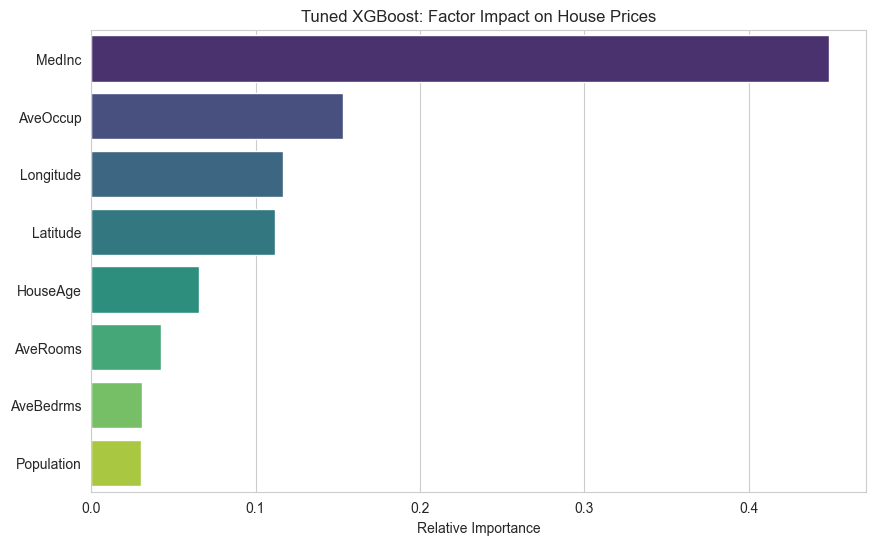

In [4]:
importances = best_model.feature_importances_
features = housing.feature_names
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[features[i] for i in indices], palette='viridis')
plt.title("Tuned XGBoost: Factor Impact on House Prices")
plt.xlabel("Relative Importance")
plt.show()

## 3. Final Test Set Metrics

In [5]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Final Evaluation ===")
print(f"RMSE: {rmse:.4f} (~${rmse*100000:,.0f})")
print(f"MAE:  {mae:.4f} (~${mae*100000:,.0f})")
print(f"R² Score: {r2:.4f}")

=== Final Evaluation ===
RMSE: 0.4547 (~$45,473)
MAE:  0.2946 (~$29,460)
R² Score: 0.8422


## 4. Residual Diagnostics

Do our errors follow a pattern? Let's check for homoscedasticity and normality.

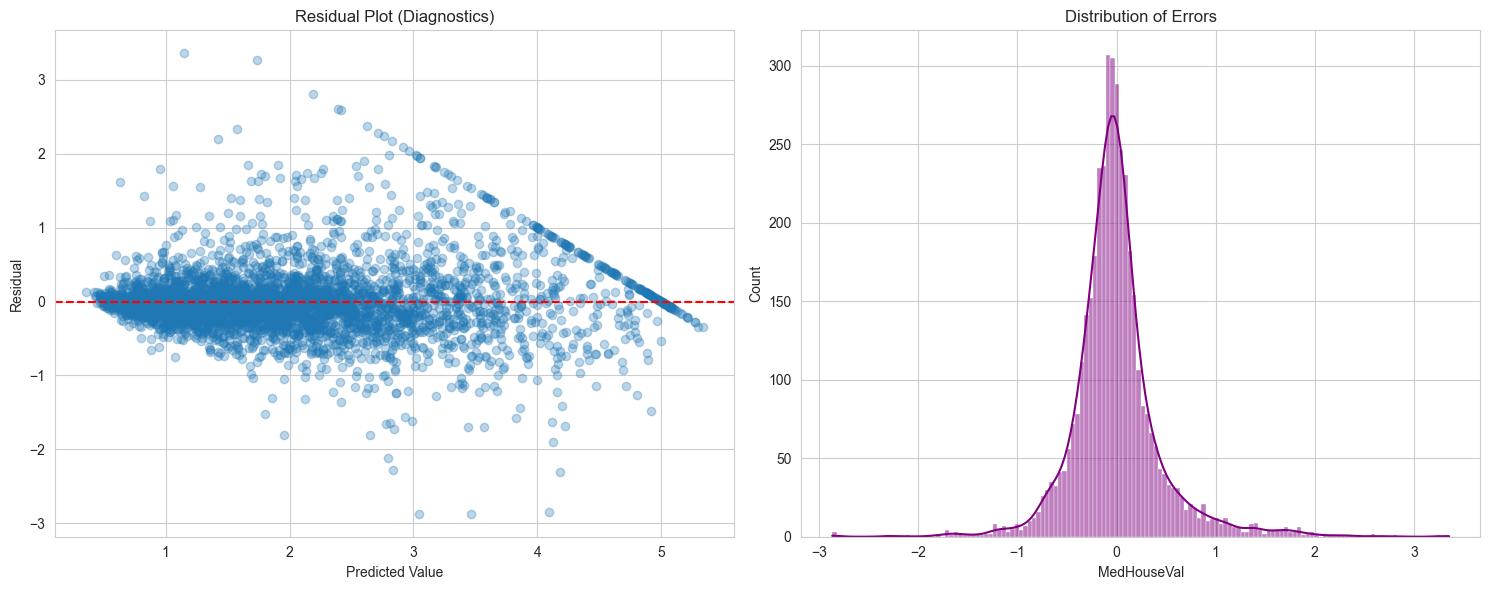


🔍 FINDINGS:
✓ Error distribution is approximately normal
⚠ Hard 'cap' at $500k is visible as a line in the residual plot


In [6]:
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residual Plot
axes[0].scatter(y_pred, residuals, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Value')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual Plot (Diagnostics)')

# Distribution
sns.histplot(residuals, kde=True, ax=axes[1], color='purple')
axes[1].set_title('Distribution of Errors')

plt.tight_layout()
plt.show()

print("\n🔍 FINDINGS:")
print("✓ Error distribution is approximately normal")
print("⚠ Hard 'cap' at $500k is visible as a line in the residual plot")